# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/data'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

#helper.download_extract('mnist', data_dir)
#helper.download_extract('celeba', data_dir)

## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

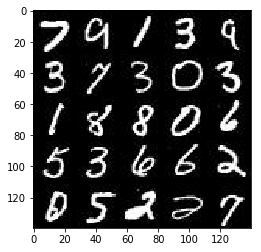

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

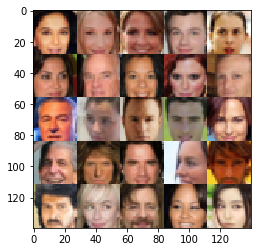

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32,
        (None, image_width, image_height, image_channels),
        name='input_real')
    input_z = tf.placeholder(tf.float32,
        (None, z_dim),
        name='input_z')
    learn_rate = tf.placeholder(tf.float32,
        name='learn_rate')

    return (input_real, input_z, learn_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
# Zero-centered Normal distribution weights initializer
def w_init(stddev=0.02):
    return tf.random_normal_initializer(stddev=stddev)

In [7]:
import numpy as np

def discriminator(images, reuse=False, alpha=0.2, prnt=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    conv_depth = [32, 64, 128, 256] # [64, 128, 256]
    conv_ksize = [3, 5, 5, 5]
    with tf.variable_scope('discriminator', reuse=reuse):
        '''
        tf.layers.conv2d(inputs, filters, kernel_size, strides=(1, 1), padding='valid', ...
        '''
       
        # CONV 1
        conv_1 = tf.layers.conv2d(
            images, conv_depth[0], conv_ksize[0], strides=1, padding='same',
            kernel_initializer=w_init()) # Convolution
        conv_1 = tf.layers.batch_normalization(conv_1, training=True) # Batchnorm
        conv_1 = tf.maximum(alpha * conv_1, conv_1) # Leaky_ReLU
        if prnt: print('CONV 1: {}'.format(conv_1.get_shape().as_list()))
        
        # CONV 2
        conv_2 =  tf.layers.conv2d(
            conv_1, conv_depth[1], conv_ksize[1], strides=2, padding='same',
            kernel_initializer=w_init()) # Convolution
        conv_2 = tf.layers.batch_normalization(conv_2, training=True) # Batchnorm
        conv_2 = tf.maximum(alpha * conv_2, conv_2) # Leaky_ReLU
        if prnt: print('CONV 2: {}'.format(conv_2.get_shape().as_list()))
        
        # CONV 3
        conv_3 =  tf.layers.conv2d(
            conv_2, conv_depth[2], conv_ksize[2], strides=2, padding='same',
            kernel_initializer=w_init()) # Convolution
        conv_3 = tf.layers.batch_normalization(conv_3, training=True) # Batchnorm
        conv_3 = tf.maximum(alpha * conv_3, conv_3) # Leaky_ReLU
        if prnt: print('CONV 3: {}'.format(conv_3.get_shape().as_list()))
        
        # CONV 4
        conv_4 =  tf.layers.conv2d(
            conv_3, conv_depth[3], conv_ksize[3], strides=2, padding='same',
            kernel_initializer=w_init()) # Convolution
        conv_4 = tf.layers.batch_normalization(conv_4, training=True) # Batchnorm
        conv_4 = tf.maximum(alpha * conv_4, conv_4) # Leaky_ReLU
        if prnt: print('CONV 4: {}'.format(conv_4.get_shape().as_list()))
        
        # Logits and Output
        logits = tf.reshape(conv_4, (-1, np.prod(conv_4.get_shape().as_list()[1:]))) # Flatten
        logits = tf.layers.dense(logits, 1,
            kernel_initializer=w_init()) # Fully connected layer
        output = tf.sigmoid(logits) # Sigmoid activation for classification
        if prnt: print('Output: {}'.format(output.get_shape().as_list()))
        
    return (output, logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

CONV 1: [None, 28, 28, 32]
CONV 2: [None, 14, 14, 64]
CONV 3: [None, 7, 7, 128]
CONV 4: [None, 4, 4, 256]
Output: [None, 1]
CONV 1: [None, 28, 28, 32]
CONV 2: [None, 14, 14, 64]
CONV 3: [None, 7, 7, 128]
CONV 4: [None, 4, 4, 256]
Output: [None, 1]
Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2, img_size=28, prnt=False):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    conv_depth = [128, 64, 32, out_channel_dim]
    conv_ksize = [5, 5, 5, 3]
    
    with tf.variable_scope('generator', reuse=not is_train):
        '''
        tf.layers.conv2d_transpose(inputs, filters, kernel_size, strides=(1, 1), padding='valid', ...
        '''
        # Fully connected layer
        dim = [4, 256]
        layer_0 = tf.layers.dense(z, dim[0]**2*dim[1], kernel_initializer=w_init())
        layer_0 = tf.reshape(layer_0, (-1, dim[0], dim[0], dim[1])) # First 'feature' stack
        layer_0 = tf.layers.batch_normalization(layer_0, training=is_train) # Batchnorm
        layer_0 =  tf.maximum(alpha * layer_0, layer_0) # Leaky_ReLU
        if prnt: print('FC Layer 0: {}'.format(layer_0.get_shape().as_list()))
        
        # CONV_T 0
        conv_0 = tf.layers.conv2d_transpose(
            layer_0, conv_depth[0], conv_ksize[0], strides=2, padding='same',
            kernel_initializer=w_init()) # Convolution
        conv_0 = tf.layers.batch_normalization(conv_0, training=is_train) # Batchnorm
        conv_0 = tf.maximum(alpha * conv_0, conv_0) # Leaky_ReLU
        if prnt: print('CONV_T 0: {}'.format(conv_0.get_shape().as_list()))
        
        # CONV_T 1
        conv_1 = tf.layers.conv2d_transpose(
            conv_0, conv_depth[1], conv_ksize[1], strides=2, padding='same',
            kernel_initializer=w_init()) # Convolution
        conv_1 = tf.layers.batch_normalization(conv_1, training=is_train) # Batchnorm
        conv_1 = tf.maximum(alpha * conv_1, conv_1) # Leaky_ReLU
        if prnt: print('CONV_T 1: {}'.format(conv_1.get_shape().as_list()))
        
        # CONV_T 2
        conv_2 = tf.layers.conv2d_transpose(
            conv_1, conv_depth[2], conv_ksize[2], strides=2, padding='same',
            kernel_initializer=w_init()) # Convolution
        conv_2 = tf.layers.batch_normalization(conv_2, training=is_train) # Batchnorm
        conv_2 = tf.maximum(alpha * conv_2, conv_2) # Leaky_ReLU
        if prnt: print('CONV_T 2: {}'.format(conv_2.get_shape().as_list()))
        
        # CONV_T 3
        conv_3 = tf.layers.conv2d_transpose(
            conv_2, conv_depth[3], conv_ksize[3], strides=1, padding='same',
            kernel_initializer=w_init()) # Convolution
        if prnt: print('CONV_T 3: {}'.format(conv_3.get_shape().as_list()))
        
        # Crop
        crop = tf.slice(conv_3, [0,2,2,0], [-1,28,28,-1])
        if prnt: print('Crop : {}'.format(crop.get_shape().as_list()))
                
        # Output
        output = tf.tanh(crop) # 
        if prnt: print('Output: {}'.format(output.get_shape().as_list()))    
    
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

tests.test_generator(generator, tf)

FC Layer 0: [None, 4, 4, 256]
CONV_T 0: [None, 8, 8, 128]
CONV_T 1: [None, 16, 16, 64]
CONV_T 2: [None, 32, 32, 32]
CONV_T 3: [None, 32, 32, 5]
Crop : [None, 28, 28, 5]
Output: [None, 28, 28, 5]
FC Layer 0: [None, 4, 4, 256]
CONV_T 0: [None, 8, 8, 128]
CONV_T 1: [None, 16, 16, 64]
CONV_T 2: [None, 32, 32, 32]
CONV_T 3: [None, 32, 32, 5]
Crop : [None, 28, 28, 5]
Output: [None, 28, 28, 5]
Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    # Modified version of 'model_loss()' in DCGAN lesson
    g_model = generator(input_z, out_channel_dim) # Generator output
    d_model_real, d_logits_real = discriminator(input_real) # Discriminator output with real images
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True) # Discriminator output with generator images

    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits( # Logits: Yes | Labels: Yes
            logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits( # Logits: No  | Labels: No
            logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss      = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits( # Logits: No  | Labels: Yes
            logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake # Combine loss for real and fake inputs
    
    return (d_loss, g_loss)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Modified version of 'model_opt()' in DCGAN lesson
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize and update tf.layers.batch_normalization layers population statistics
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(
            learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(
            learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return (d_train_opt, g_train_opt)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`
- `show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
!mkdir checkpoints

mkdir: cannot create directory ‘checkpoints’: File exists


In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, n_files):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    # tf.reset_default_graph()
    
    # Create TF Placeholders for the Neural Network
    input_real, input_z, learn_rate = model_inputs(
        image_width=data_shape[1],
        image_height=data_shape[2],
        image_channels=data_shape[3],
        z_dim=z_dim)
    
    # Build the GANs for training and calculate the loss
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim=data_shape[3])
    
    # Create the optimization operations for the GANs
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    # Model saver  
    saver = tf.train.Saver()
    
    print_every = 1000 // batch_size
    show_every = 10000 // batch_size
    losses = []
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_num, batch_images in enumerate(get_batches(batch_size)):
                # TODO: Train Model
                steps += 1
                
                # Sample random noise for G
                c = 2 # Tip from slack. Give the generator more tries to find good activations
                batch_z = np.random.uniform(-1, 1, size=(batch_size * c, z_dim))
                
                # Run optimizers
                _ = sess.run(
                    d_train_opt,
                    feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(
                    g_train_opt,
                    feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Step {}...".format(steps),
                          "Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Batch {}/{}...".format(batch_num, n_files // batch_size),
                          "D Loss: {:.4f}...".format(train_loss_d),
                          "G Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

        saver.save(sess, './checkpoints/generator.ckpt')

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Step 15... Epoch 1/2... Batch 14/937... D Loss: 0.2205... G Loss: 2.2712
Step 30... Epoch 1/2... Batch 29/937... D Loss: 1.8511... G Loss: 0.2868
Step 45... Epoch 1/2... Batch 44/937... D Loss: 0.1929... G Loss: 2.5617
Step 60... Epoch 1/2... Batch 59/937... D Loss: 0.2806... G Loss: 2.2574
Step 75... Epoch 1/2... Batch 74/937... D Loss: 1.1526... G Loss: 0.5477
Step 90... Epoch 1/2... Batch 89/937... D Loss: 0.1499... G Loss: 2.6395
Step 105... Epoch 1/2... Batch 104/937... D Loss: 0.1746... G Loss: 2.3475
Step 120... Epoch 1/2... Batch 119/937... D Loss: 1.7220... G Loss: 0.2829
Step 135... Epoch 1/2... Batch 134/937... D Loss: 0.0902... G Loss: 3.5623
Step 150... Epoch 1/2... Batch 149/937... D Loss: 0.0430... G Loss: 4.0691


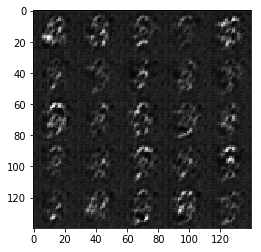

Step 165... Epoch 1/2... Batch 164/937... D Loss: 0.0230... G Loss: 4.6710
Step 180... Epoch 1/2... Batch 179/937... D Loss: 0.0296... G Loss: 4.3037
Step 195... Epoch 1/2... Batch 194/937... D Loss: 0.0204... G Loss: 5.2840
Step 210... Epoch 1/2... Batch 209/937... D Loss: 0.0358... G Loss: 4.1279
Step 225... Epoch 1/2... Batch 224/937... D Loss: 2.5844... G Loss: 0.3401
Step 240... Epoch 1/2... Batch 239/937... D Loss: 1.9219... G Loss: 0.4629
Step 255... Epoch 1/2... Batch 254/937... D Loss: 0.5433... G Loss: 5.3581
Step 270... Epoch 1/2... Batch 269/937... D Loss: 0.2589... G Loss: 2.2627
Step 285... Epoch 1/2... Batch 284/937... D Loss: 0.2375... G Loss: 2.0669
Step 300... Epoch 1/2... Batch 299/937... D Loss: 0.4227... G Loss: 1.2811


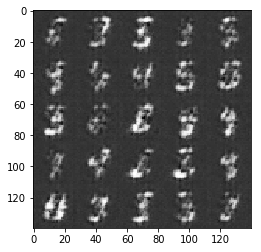

Step 315... Epoch 1/2... Batch 314/937... D Loss: 0.1014... G Loss: 4.2235
Step 330... Epoch 1/2... Batch 329/937... D Loss: 1.9964... G Loss: 0.2047
Step 345... Epoch 1/2... Batch 344/937... D Loss: 0.2623... G Loss: 2.5965
Step 360... Epoch 1/2... Batch 359/937... D Loss: 0.1535... G Loss: 2.8180
Step 375... Epoch 1/2... Batch 374/937... D Loss: 0.0753... G Loss: 3.3681
Step 390... Epoch 1/2... Batch 389/937... D Loss: 0.0771... G Loss: 3.3687
Step 405... Epoch 1/2... Batch 404/937... D Loss: 0.0367... G Loss: 4.3941
Step 420... Epoch 1/2... Batch 419/937... D Loss: 0.0558... G Loss: 3.7079
Step 435... Epoch 1/2... Batch 434/937... D Loss: 0.0490... G Loss: 3.8924
Step 450... Epoch 1/2... Batch 449/937... D Loss: 0.0769... G Loss: 3.3547
Step 465... Epoch 1/2... Batch 464/937... D Loss: 0.0739... G Loss: 3.8118


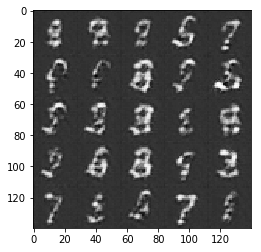

Step 480... Epoch 1/2... Batch 479/937... D Loss: 0.0336... G Loss: 4.2238
Step 495... Epoch 1/2... Batch 494/937... D Loss: 1.4908... G Loss: 0.9086
Step 510... Epoch 1/2... Batch 509/937... D Loss: 0.2051... G Loss: 2.4969
Step 525... Epoch 1/2... Batch 524/937... D Loss: 0.2673... G Loss: 2.3995
Step 540... Epoch 1/2... Batch 539/937... D Loss: 0.1027... G Loss: 3.3280
Step 555... Epoch 1/2... Batch 554/937... D Loss: 0.1124... G Loss: 3.1308
Step 570... Epoch 1/2... Batch 569/937... D Loss: 0.0970... G Loss: 2.8752
Step 585... Epoch 1/2... Batch 584/937... D Loss: 0.2226... G Loss: 1.9319
Step 600... Epoch 1/2... Batch 599/937... D Loss: 0.0590... G Loss: 3.5897
Step 615... Epoch 1/2... Batch 614/937... D Loss: 0.0602... G Loss: 3.5499


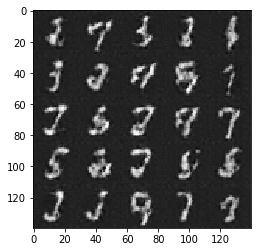

Step 630... Epoch 1/2... Batch 629/937... D Loss: 2.7671... G Loss: 11.3164
Step 645... Epoch 1/2... Batch 644/937... D Loss: 0.1218... G Loss: 3.0376
Step 660... Epoch 1/2... Batch 659/937... D Loss: 0.0958... G Loss: 3.6341
Step 675... Epoch 1/2... Batch 674/937... D Loss: 0.0919... G Loss: 3.2368
Step 690... Epoch 1/2... Batch 689/937... D Loss: 0.0522... G Loss: 3.7820
Step 705... Epoch 1/2... Batch 704/937... D Loss: 0.0210... G Loss: 5.1399
Step 720... Epoch 1/2... Batch 719/937... D Loss: 0.0247... G Loss: 4.4935
Step 735... Epoch 1/2... Batch 734/937... D Loss: 0.0347... G Loss: 4.3412
Step 750... Epoch 1/2... Batch 749/937... D Loss: 0.0439... G Loss: 3.8531
Step 765... Epoch 1/2... Batch 764/937... D Loss: 0.1370... G Loss: 2.4805
Step 780... Epoch 1/2... Batch 779/937... D Loss: 0.4883... G Loss: 2.0836


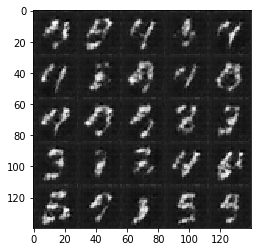

Step 795... Epoch 1/2... Batch 794/937... D Loss: 0.3105... G Loss: 2.0583
Step 810... Epoch 1/2... Batch 809/937... D Loss: 0.4203... G Loss: 2.1204
Step 825... Epoch 1/2... Batch 824/937... D Loss: 1.5964... G Loss: 4.9656
Step 840... Epoch 1/2... Batch 839/937... D Loss: 0.3155... G Loss: 2.0017
Step 855... Epoch 1/2... Batch 854/937... D Loss: 0.3490... G Loss: 2.4581
Step 870... Epoch 1/2... Batch 869/937... D Loss: 0.2244... G Loss: 2.1246
Step 885... Epoch 1/2... Batch 884/937... D Loss: 0.3071... G Loss: 1.8101
Step 900... Epoch 1/2... Batch 899/937... D Loss: 0.2304... G Loss: 2.0123
Step 915... Epoch 1/2... Batch 914/937... D Loss: 0.1827... G Loss: 4.0851
Step 930... Epoch 1/2... Batch 929/937... D Loss: 0.1730... G Loss: 2.4574


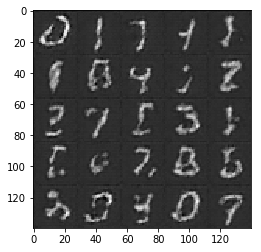

Step 945... Epoch 2/2... Batch 7/937... D Loss: 0.4268... G Loss: 2.6226
Step 960... Epoch 2/2... Batch 22/937... D Loss: 0.1772... G Loss: 3.0230
Step 975... Epoch 2/2... Batch 37/937... D Loss: 0.2076... G Loss: 2.3234
Step 990... Epoch 2/2... Batch 52/937... D Loss: 0.1526... G Loss: 3.0908
Step 1005... Epoch 2/2... Batch 67/937... D Loss: 0.5391... G Loss: 4.6933
Step 1020... Epoch 2/2... Batch 82/937... D Loss: 0.3858... G Loss: 1.9711
Step 1035... Epoch 2/2... Batch 97/937... D Loss: 0.1958... G Loss: 2.8682
Step 1050... Epoch 2/2... Batch 112/937... D Loss: 2.5151... G Loss: 0.1214
Step 1065... Epoch 2/2... Batch 127/937... D Loss: 0.1781... G Loss: 2.4536
Step 1080... Epoch 2/2... Batch 142/937... D Loss: 0.1149... G Loss: 2.9431


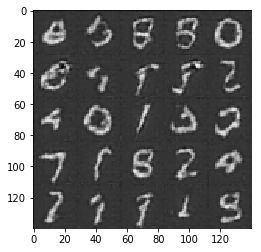

Step 1095... Epoch 2/2... Batch 157/937... D Loss: 0.0853... G Loss: 3.1872
Step 1110... Epoch 2/2... Batch 172/937... D Loss: 0.0480... G Loss: 3.7446
Step 1125... Epoch 2/2... Batch 187/937... D Loss: 0.4448... G Loss: 3.4519
Step 1140... Epoch 2/2... Batch 202/937... D Loss: 0.4824... G Loss: 1.4677
Step 1155... Epoch 2/2... Batch 217/937... D Loss: 0.2348... G Loss: 2.7376
Step 1170... Epoch 2/2... Batch 232/937... D Loss: 0.2318... G Loss: 2.0946
Step 1185... Epoch 2/2... Batch 247/937... D Loss: 0.1459... G Loss: 2.7870
Step 1200... Epoch 2/2... Batch 262/937... D Loss: 0.1329... G Loss: 3.8561
Step 1215... Epoch 2/2... Batch 277/937... D Loss: 0.0862... G Loss: 3.2710
Step 1230... Epoch 2/2... Batch 292/937... D Loss: 0.7592... G Loss: 3.2152
Step 1245... Epoch 2/2... Batch 307/937... D Loss: 0.4665... G Loss: 2.3092


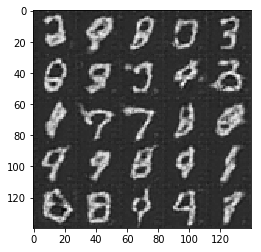

Step 1260... Epoch 2/2... Batch 322/937... D Loss: 0.1972... G Loss: 2.5168
Step 1275... Epoch 2/2... Batch 337/937... D Loss: 0.1708... G Loss: 2.4971
Step 1290... Epoch 2/2... Batch 352/937... D Loss: 0.1438... G Loss: 2.5032
Step 1305... Epoch 2/2... Batch 367/937... D Loss: 0.7804... G Loss: 4.1753
Step 1320... Epoch 2/2... Batch 382/937... D Loss: 0.1697... G Loss: 2.4881
Step 1335... Epoch 2/2... Batch 397/937... D Loss: 0.2724... G Loss: 1.7923
Step 1350... Epoch 2/2... Batch 412/937... D Loss: 0.1380... G Loss: 3.7124
Step 1365... Epoch 2/2... Batch 427/937... D Loss: 0.1119... G Loss: 3.2644
Step 1380... Epoch 2/2... Batch 442/937... D Loss: 0.1216... G Loss: 3.2855
Step 1395... Epoch 2/2... Batch 457/937... D Loss: 0.1690... G Loss: 2.2505


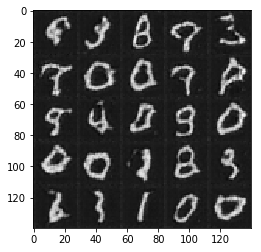

Step 1410... Epoch 2/2... Batch 472/937... D Loss: 0.1286... G Loss: 2.4722
Step 1425... Epoch 2/2... Batch 487/937... D Loss: 0.5229... G Loss: 2.1601
Step 1440... Epoch 2/2... Batch 502/937... D Loss: 0.6219... G Loss: 1.1327
Step 1455... Epoch 2/2... Batch 517/937... D Loss: 0.7979... G Loss: 0.8503
Step 1470... Epoch 2/2... Batch 532/937... D Loss: 0.2426... G Loss: 2.2520
Step 1485... Epoch 2/2... Batch 547/937... D Loss: 0.1284... G Loss: 3.3622
Step 1500... Epoch 2/2... Batch 562/937... D Loss: 0.1530... G Loss: 2.8618
Step 1515... Epoch 2/2... Batch 577/937... D Loss: 0.3183... G Loss: 4.4800
Step 1530... Epoch 2/2... Batch 592/937... D Loss: 0.4506... G Loss: 1.7283
Step 1545... Epoch 2/2... Batch 607/937... D Loss: 0.3384... G Loss: 1.7905
Step 1560... Epoch 2/2... Batch 622/937... D Loss: 0.6281... G Loss: 1.0137


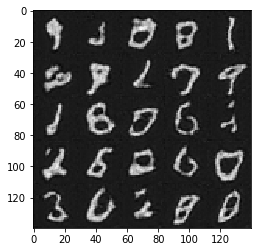

Step 1575... Epoch 2/2... Batch 637/937... D Loss: 0.1166... G Loss: 2.9277
Step 1590... Epoch 2/2... Batch 652/937... D Loss: 0.1120... G Loss: 2.7842
Step 1605... Epoch 2/2... Batch 667/937... D Loss: 0.5766... G Loss: 1.4463
Step 1620... Epoch 2/2... Batch 682/937... D Loss: 0.3446... G Loss: 1.8542
Step 1635... Epoch 2/2... Batch 697/937... D Loss: 0.2452... G Loss: 2.0504
Step 1650... Epoch 2/2... Batch 712/937... D Loss: 0.1313... G Loss: 2.7704
Step 1665... Epoch 2/2... Batch 727/937... D Loss: 0.1300... G Loss: 3.2772
Step 1680... Epoch 2/2... Batch 742/937... D Loss: 0.0793... G Loss: 4.0302
Step 1695... Epoch 2/2... Batch 757/937... D Loss: 0.1426... G Loss: 3.1611
Step 1710... Epoch 2/2... Batch 772/937... D Loss: 1.3585... G Loss: 0.5424


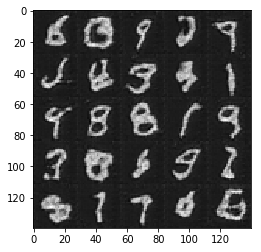

Step 1725... Epoch 2/2... Batch 787/937... D Loss: 0.4831... G Loss: 1.6121
Step 1740... Epoch 2/2... Batch 802/937... D Loss: 0.3944... G Loss: 1.7732
Step 1755... Epoch 2/2... Batch 817/937... D Loss: 0.4797... G Loss: 3.0632
Step 1770... Epoch 2/2... Batch 832/937... D Loss: 0.9181... G Loss: 0.6692
Step 1785... Epoch 2/2... Batch 847/937... D Loss: 0.2138... G Loss: 2.2004
Step 1800... Epoch 2/2... Batch 862/937... D Loss: 0.2432... G Loss: 2.0288
Step 1815... Epoch 2/2... Batch 877/937... D Loss: 0.3816... G Loss: 2.4244
Step 1830... Epoch 2/2... Batch 892/937... D Loss: 0.4894... G Loss: 1.2535
Step 1845... Epoch 2/2... Batch 907/937... D Loss: 0.1276... G Loss: 3.0209
Step 1860... Epoch 2/2... Batch 922/937... D Loss: 0.1266... G Loss: 3.2687


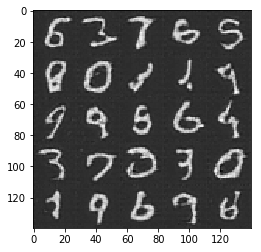

In [16]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2
files = glob(os.path.join(data_dir, 'mnist/*.jpg'))
#files = files[:5001]
mnist_dataset = helper.Dataset('mnist', files)
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode, len(files))

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Step 15... Epoch 1/1... Batch 14/3165... D Loss: 0.2598... G Loss: 2.0587
Step 30... Epoch 1/1... Batch 29/3165... D Loss: 0.2264... G Loss: 2.1724
Step 45... Epoch 1/1... Batch 44/3165... D Loss: 0.2895... G Loss: 1.8761
Step 60... Epoch 1/1... Batch 59/3165... D Loss: 0.5089... G Loss: 3.0082
Step 75... Epoch 1/1... Batch 74/3165... D Loss: 0.4454... G Loss: 2.6593
Step 90... Epoch 1/1... Batch 89/3165... D Loss: 0.3698... G Loss: 2.3977
Step 105... Epoch 1/1... Batch 104/3165... D Loss: 0.6014... G Loss: 1.2306
Step 120... Epoch 1/1... Batch 119/3165... D Loss: 6.1954... G Loss: 13.2898
Step 135... Epoch 1/1... Batch 134/3165... D Loss: 0.3512... G Loss: 3.4954
Step 150... Epoch 1/1... Batch 149/3165... D Loss: 0.5347... G Loss: 1.4936


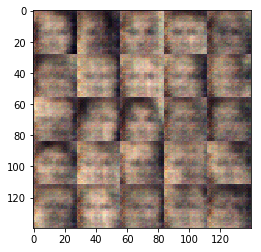

Step 165... Epoch 1/1... Batch 164/3165... D Loss: 1.3840... G Loss: 0.4504
Step 180... Epoch 1/1... Batch 179/3165... D Loss: 1.1837... G Loss: 0.7262
Step 195... Epoch 1/1... Batch 194/3165... D Loss: 1.4509... G Loss: 0.4153
Step 210... Epoch 1/1... Batch 209/3165... D Loss: 1.1263... G Loss: 0.7936
Step 225... Epoch 1/1... Batch 224/3165... D Loss: 0.8968... G Loss: 1.2529
Step 240... Epoch 1/1... Batch 239/3165... D Loss: 0.7750... G Loss: 3.4169
Step 255... Epoch 1/1... Batch 254/3165... D Loss: 0.7334... G Loss: 1.1212
Step 270... Epoch 1/1... Batch 269/3165... D Loss: 0.4570... G Loss: 1.8245
Step 285... Epoch 1/1... Batch 284/3165... D Loss: 0.9381... G Loss: 0.7862
Step 300... Epoch 1/1... Batch 299/3165... D Loss: 0.4864... G Loss: 1.5700


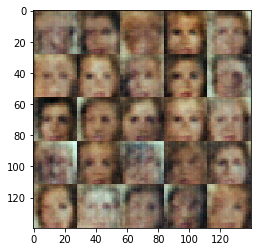

Step 315... Epoch 1/1... Batch 314/3165... D Loss: 0.9089... G Loss: 0.7702
Step 330... Epoch 1/1... Batch 329/3165... D Loss: 0.5901... G Loss: 1.3793
Step 345... Epoch 1/1... Batch 344/3165... D Loss: 0.8089... G Loss: 0.8942
Step 360... Epoch 1/1... Batch 359/3165... D Loss: 0.7152... G Loss: 2.7623
Step 375... Epoch 1/1... Batch 374/3165... D Loss: 0.8825... G Loss: 1.0568
Step 390... Epoch 1/1... Batch 389/3165... D Loss: 0.5779... G Loss: 1.9840
Step 405... Epoch 1/1... Batch 404/3165... D Loss: 1.8476... G Loss: 4.6348
Step 420... Epoch 1/1... Batch 419/3165... D Loss: 0.7273... G Loss: 2.4229
Step 435... Epoch 1/1... Batch 434/3165... D Loss: 1.0882... G Loss: 1.7151
Step 450... Epoch 1/1... Batch 449/3165... D Loss: 0.8149... G Loss: 1.3458
Step 465... Epoch 1/1... Batch 464/3165... D Loss: 0.9317... G Loss: 0.8339


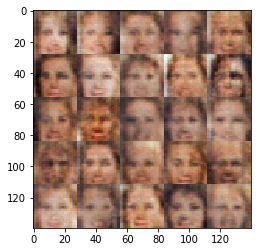

Step 480... Epoch 1/1... Batch 479/3165... D Loss: 0.7513... G Loss: 1.4932
Step 495... Epoch 1/1... Batch 494/3165... D Loss: 0.6973... G Loss: 1.7782
Step 510... Epoch 1/1... Batch 509/3165... D Loss: 0.7018... G Loss: 1.2704
Step 525... Epoch 1/1... Batch 524/3165... D Loss: 0.7202... G Loss: 1.1699
Step 540... Epoch 1/1... Batch 539/3165... D Loss: 0.8492... G Loss: 1.5092
Step 555... Epoch 1/1... Batch 554/3165... D Loss: 0.7455... G Loss: 1.3488
Step 570... Epoch 1/1... Batch 569/3165... D Loss: 0.9427... G Loss: 2.4659
Step 585... Epoch 1/1... Batch 584/3165... D Loss: 1.1165... G Loss: 0.6573
Step 600... Epoch 1/1... Batch 599/3165... D Loss: 0.7758... G Loss: 1.7767
Step 615... Epoch 1/1... Batch 614/3165... D Loss: 1.0526... G Loss: 0.6188


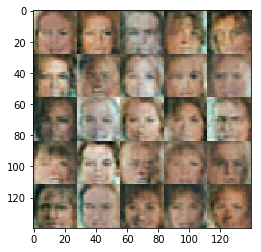

Step 630... Epoch 1/1... Batch 629/3165... D Loss: 0.6659... G Loss: 1.7269
Step 645... Epoch 1/1... Batch 644/3165... D Loss: 1.1614... G Loss: 0.5877
Step 660... Epoch 1/1... Batch 659/3165... D Loss: 1.0562... G Loss: 0.6291
Step 675... Epoch 1/1... Batch 674/3165... D Loss: 1.1515... G Loss: 3.1027
Step 690... Epoch 1/1... Batch 689/3165... D Loss: 0.7523... G Loss: 1.2416
Step 705... Epoch 1/1... Batch 704/3165... D Loss: 0.7794... G Loss: 1.7445
Step 720... Epoch 1/1... Batch 719/3165... D Loss: 0.7802... G Loss: 1.1887
Step 735... Epoch 1/1... Batch 734/3165... D Loss: 0.7026... G Loss: 1.0865
Step 750... Epoch 1/1... Batch 749/3165... D Loss: 0.6738... G Loss: 1.9701
Step 765... Epoch 1/1... Batch 764/3165... D Loss: 0.6920... G Loss: 1.0401
Step 780... Epoch 1/1... Batch 779/3165... D Loss: 0.6105... G Loss: 1.7587


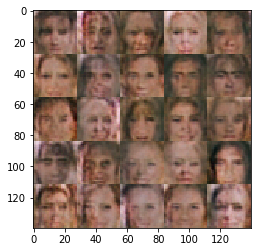

Step 795... Epoch 1/1... Batch 794/3165... D Loss: 0.6981... G Loss: 1.2813
Step 810... Epoch 1/1... Batch 809/3165... D Loss: 0.8055... G Loss: 1.1215
Step 825... Epoch 1/1... Batch 824/3165... D Loss: 0.7789... G Loss: 1.4865
Step 840... Epoch 1/1... Batch 839/3165... D Loss: 0.7239... G Loss: 2.6196
Step 855... Epoch 1/1... Batch 854/3165... D Loss: 0.5567... G Loss: 1.5225
Step 870... Epoch 1/1... Batch 869/3165... D Loss: 0.6857... G Loss: 1.0820
Step 885... Epoch 1/1... Batch 884/3165... D Loss: 0.5791... G Loss: 1.5344
Step 900... Epoch 1/1... Batch 899/3165... D Loss: 0.6887... G Loss: 2.2899
Step 915... Epoch 1/1... Batch 914/3165... D Loss: 0.6955... G Loss: 1.2573
Step 930... Epoch 1/1... Batch 929/3165... D Loss: 0.6442... G Loss: 1.8468


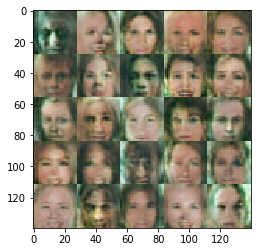

Step 945... Epoch 1/1... Batch 944/3165... D Loss: 0.6420... G Loss: 1.7785
Step 960... Epoch 1/1... Batch 959/3165... D Loss: 0.6104... G Loss: 1.3712
Step 975... Epoch 1/1... Batch 974/3165... D Loss: 0.6997... G Loss: 1.2385
Step 990... Epoch 1/1... Batch 989/3165... D Loss: 0.5925... G Loss: 1.5477
Step 1005... Epoch 1/1... Batch 1004/3165... D Loss: 0.7393... G Loss: 1.1175
Step 1020... Epoch 1/1... Batch 1019/3165... D Loss: 1.4641... G Loss: 3.6762
Step 1035... Epoch 1/1... Batch 1034/3165... D Loss: 0.6850... G Loss: 1.4354
Step 1050... Epoch 1/1... Batch 1049/3165... D Loss: 0.5871... G Loss: 1.3323
Step 1065... Epoch 1/1... Batch 1064/3165... D Loss: 0.8269... G Loss: 0.8325
Step 1080... Epoch 1/1... Batch 1079/3165... D Loss: 0.6121... G Loss: 1.9238


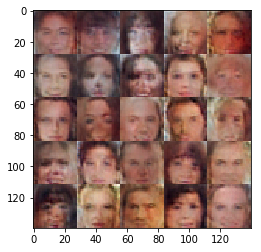

Step 1095... Epoch 1/1... Batch 1094/3165... D Loss: 0.8728... G Loss: 0.7598
Step 1110... Epoch 1/1... Batch 1109/3165... D Loss: 0.8933... G Loss: 0.7730
Step 1125... Epoch 1/1... Batch 1124/3165... D Loss: 0.6012... G Loss: 1.6277
Step 1140... Epoch 1/1... Batch 1139/3165... D Loss: 0.3961... G Loss: 1.9838
Step 1155... Epoch 1/1... Batch 1154/3165... D Loss: 0.5995... G Loss: 1.4445
Step 1170... Epoch 1/1... Batch 1169/3165... D Loss: 0.7702... G Loss: 0.9038
Step 1185... Epoch 1/1... Batch 1184/3165... D Loss: 0.6565... G Loss: 1.0707
Step 1200... Epoch 1/1... Batch 1199/3165... D Loss: 0.7040... G Loss: 1.8033
Step 1215... Epoch 1/1... Batch 1214/3165... D Loss: 0.8420... G Loss: 1.8336
Step 1230... Epoch 1/1... Batch 1229/3165... D Loss: 1.6692... G Loss: 3.8096
Step 1245... Epoch 1/1... Batch 1244/3165... D Loss: 0.6530... G Loss: 1.1168


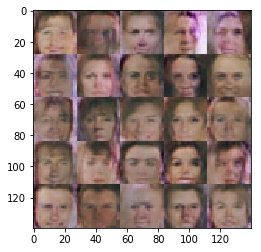

Step 1260... Epoch 1/1... Batch 1259/3165... D Loss: 1.2245... G Loss: 0.4988
Step 1275... Epoch 1/1... Batch 1274/3165... D Loss: 0.8911... G Loss: 0.7987
Step 1290... Epoch 1/1... Batch 1289/3165... D Loss: 0.6418... G Loss: 1.3178
Step 1305... Epoch 1/1... Batch 1304/3165... D Loss: 0.7498... G Loss: 2.0720
Step 1320... Epoch 1/1... Batch 1319/3165... D Loss: 0.7097... G Loss: 1.2254
Step 1335... Epoch 1/1... Batch 1334/3165... D Loss: 1.1758... G Loss: 0.5097
Step 1350... Epoch 1/1... Batch 1349/3165... D Loss: 1.2793... G Loss: 0.4471
Step 1365... Epoch 1/1... Batch 1364/3165... D Loss: 0.7481... G Loss: 1.2445
Step 1380... Epoch 1/1... Batch 1379/3165... D Loss: 0.5059... G Loss: 1.6756
Step 1395... Epoch 1/1... Batch 1394/3165... D Loss: 0.6085... G Loss: 2.5199


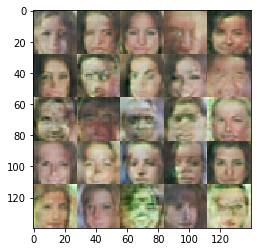

Step 1410... Epoch 1/1... Batch 1409/3165... D Loss: 0.9426... G Loss: 0.7002
Step 1425... Epoch 1/1... Batch 1424/3165... D Loss: 1.0507... G Loss: 2.2191
Step 1440... Epoch 1/1... Batch 1439/3165... D Loss: 0.9347... G Loss: 0.7275
Step 1455... Epoch 1/1... Batch 1454/3165... D Loss: 0.7645... G Loss: 1.6917
Step 1470... Epoch 1/1... Batch 1469/3165... D Loss: 0.8575... G Loss: 0.9289
Step 1485... Epoch 1/1... Batch 1484/3165... D Loss: 0.7107... G Loss: 1.0439
Step 1500... Epoch 1/1... Batch 1499/3165... D Loss: 0.6495... G Loss: 1.2714
Step 1515... Epoch 1/1... Batch 1514/3165... D Loss: 0.8089... G Loss: 0.8145
Step 1530... Epoch 1/1... Batch 1529/3165... D Loss: 1.8758... G Loss: 0.2441
Step 1545... Epoch 1/1... Batch 1544/3165... D Loss: 1.0342... G Loss: 0.6228
Step 1560... Epoch 1/1... Batch 1559/3165... D Loss: 1.2454... G Loss: 0.4755


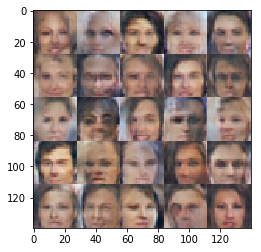

Step 1575... Epoch 1/1... Batch 1574/3165... D Loss: 0.8820... G Loss: 1.5505
Step 1590... Epoch 1/1... Batch 1589/3165... D Loss: 0.5989... G Loss: 1.3749
Step 1605... Epoch 1/1... Batch 1604/3165... D Loss: 1.1425... G Loss: 0.5824
Step 1620... Epoch 1/1... Batch 1619/3165... D Loss: 0.7572... G Loss: 0.9278
Step 1635... Epoch 1/1... Batch 1634/3165... D Loss: 1.3916... G Loss: 2.4717
Step 1650... Epoch 1/1... Batch 1649/3165... D Loss: 0.8599... G Loss: 2.0544
Step 1665... Epoch 1/1... Batch 1664/3165... D Loss: 0.7626... G Loss: 0.9337
Step 1680... Epoch 1/1... Batch 1679/3165... D Loss: 0.7774... G Loss: 2.0480
Step 1695... Epoch 1/1... Batch 1694/3165... D Loss: 0.9167... G Loss: 0.7856
Step 1710... Epoch 1/1... Batch 1709/3165... D Loss: 0.6666... G Loss: 1.1194


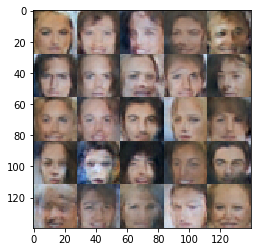

Step 1725... Epoch 1/1... Batch 1724/3165... D Loss: 0.7807... G Loss: 0.9154
Step 1740... Epoch 1/1... Batch 1739/3165... D Loss: 0.5621... G Loss: 1.6134
Step 1755... Epoch 1/1... Batch 1754/3165... D Loss: 0.7752... G Loss: 1.4189
Step 1770... Epoch 1/1... Batch 1769/3165... D Loss: 0.7226... G Loss: 1.2143
Step 1785... Epoch 1/1... Batch 1784/3165... D Loss: 0.8799... G Loss: 0.8523
Step 1800... Epoch 1/1... Batch 1799/3165... D Loss: 0.5572... G Loss: 1.8654
Step 1815... Epoch 1/1... Batch 1814/3165... D Loss: 0.9469... G Loss: 0.7659
Step 1830... Epoch 1/1... Batch 1829/3165... D Loss: 0.4941... G Loss: 1.4626
Step 1845... Epoch 1/1... Batch 1844/3165... D Loss: 0.6972... G Loss: 1.1025
Step 1860... Epoch 1/1... Batch 1859/3165... D Loss: 0.7098... G Loss: 2.5230


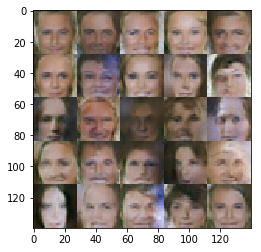

Step 1875... Epoch 1/1... Batch 1874/3165... D Loss: 1.4405... G Loss: 0.4769
Step 1890... Epoch 1/1... Batch 1889/3165... D Loss: 0.5952... G Loss: 1.7843
Step 1905... Epoch 1/1... Batch 1904/3165... D Loss: 0.7549... G Loss: 1.0951
Step 1920... Epoch 1/1... Batch 1919/3165... D Loss: 0.9594... G Loss: 1.6487
Step 1935... Epoch 1/1... Batch 1934/3165... D Loss: 0.7859... G Loss: 1.8711
Step 1950... Epoch 1/1... Batch 1949/3165... D Loss: 1.1653... G Loss: 2.0735
Step 1965... Epoch 1/1... Batch 1964/3165... D Loss: 0.7107... G Loss: 1.6037
Step 1980... Epoch 1/1... Batch 1979/3165... D Loss: 1.0641... G Loss: 0.7095
Step 1995... Epoch 1/1... Batch 1994/3165... D Loss: 0.6078... G Loss: 1.3723
Step 2010... Epoch 1/1... Batch 2009/3165... D Loss: 1.8901... G Loss: 2.9476
Step 2025... Epoch 1/1... Batch 2024/3165... D Loss: 1.0628... G Loss: 0.6490


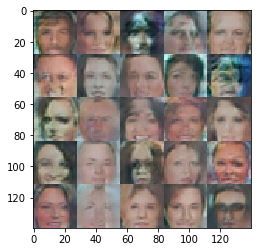

Step 2040... Epoch 1/1... Batch 2039/3165... D Loss: 0.8772... G Loss: 2.1918
Step 2055... Epoch 1/1... Batch 2054/3165... D Loss: 0.7319... G Loss: 1.2241
Step 2070... Epoch 1/1... Batch 2069/3165... D Loss: 0.7863... G Loss: 0.8544
Step 2085... Epoch 1/1... Batch 2084/3165... D Loss: 1.4599... G Loss: 0.3588
Step 2100... Epoch 1/1... Batch 2099/3165... D Loss: 1.1929... G Loss: 2.3209
Step 2115... Epoch 1/1... Batch 2114/3165... D Loss: 0.6660... G Loss: 1.1356
Step 2130... Epoch 1/1... Batch 2129/3165... D Loss: 0.6284... G Loss: 1.6472
Step 2145... Epoch 1/1... Batch 2144/3165... D Loss: 0.7477... G Loss: 1.0276
Step 2160... Epoch 1/1... Batch 2159/3165... D Loss: 1.1525... G Loss: 0.5693
Step 2175... Epoch 1/1... Batch 2174/3165... D Loss: 0.8352... G Loss: 0.8489


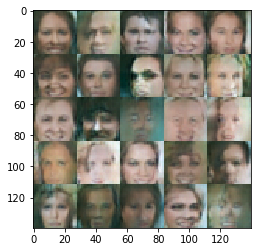

Step 2190... Epoch 1/1... Batch 2189/3165... D Loss: 1.1528... G Loss: 0.6635
Step 2205... Epoch 1/1... Batch 2204/3165... D Loss: 1.1565... G Loss: 1.9432
Step 2220... Epoch 1/1... Batch 2219/3165... D Loss: 1.0516... G Loss: 0.7147
Step 2235... Epoch 1/1... Batch 2234/3165... D Loss: 0.7628... G Loss: 1.3177
Step 2250... Epoch 1/1... Batch 2249/3165... D Loss: 0.8292... G Loss: 1.1366
Step 2265... Epoch 1/1... Batch 2264/3165... D Loss: 0.6570... G Loss: 1.7899
Step 2280... Epoch 1/1... Batch 2279/3165... D Loss: 0.9155... G Loss: 0.6851
Step 2295... Epoch 1/1... Batch 2294/3165... D Loss: 0.7232... G Loss: 1.6383
Step 2310... Epoch 1/1... Batch 2309/3165... D Loss: 0.8437... G Loss: 0.8005
Step 2325... Epoch 1/1... Batch 2324/3165... D Loss: 1.1863... G Loss: 0.5918
Step 2340... Epoch 1/1... Batch 2339/3165... D Loss: 1.0726... G Loss: 0.6504


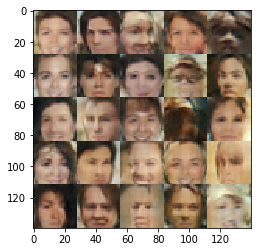

Step 2355... Epoch 1/1... Batch 2354/3165... D Loss: 0.9699... G Loss: 0.9117
Step 2370... Epoch 1/1... Batch 2369/3165... D Loss: 0.6397... G Loss: 1.4911
Step 2385... Epoch 1/1... Batch 2384/3165... D Loss: 1.5024... G Loss: 0.3716
Step 2400... Epoch 1/1... Batch 2399/3165... D Loss: 0.7861... G Loss: 1.1759
Step 2415... Epoch 1/1... Batch 2414/3165... D Loss: 0.8787... G Loss: 0.8833
Step 2430... Epoch 1/1... Batch 2429/3165... D Loss: 0.7828... G Loss: 1.1807
Step 2445... Epoch 1/1... Batch 2444/3165... D Loss: 0.6979... G Loss: 1.1265
Step 2460... Epoch 1/1... Batch 2459/3165... D Loss: 1.0073... G Loss: 0.6066
Step 2475... Epoch 1/1... Batch 2474/3165... D Loss: 1.0092... G Loss: 1.0421
Step 2490... Epoch 1/1... Batch 2489/3165... D Loss: 0.7940... G Loss: 0.9853


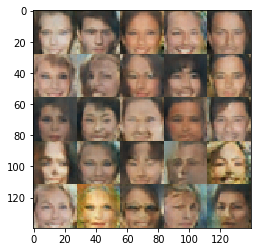

Step 2505... Epoch 1/1... Batch 2504/3165... D Loss: 0.6302... G Loss: 1.3400
Step 2520... Epoch 1/1... Batch 2519/3165... D Loss: 0.9146... G Loss: 0.9113
Step 2535... Epoch 1/1... Batch 2534/3165... D Loss: 0.6737... G Loss: 1.4328
Step 2550... Epoch 1/1... Batch 2549/3165... D Loss: 0.8700... G Loss: 1.2606
Step 2565... Epoch 1/1... Batch 2564/3165... D Loss: 0.7520... G Loss: 1.0038
Step 2580... Epoch 1/1... Batch 2579/3165... D Loss: 0.9695... G Loss: 1.4496
Step 2595... Epoch 1/1... Batch 2594/3165... D Loss: 0.6153... G Loss: 1.5637
Step 2610... Epoch 1/1... Batch 2609/3165... D Loss: 0.7726... G Loss: 1.4879
Step 2625... Epoch 1/1... Batch 2624/3165... D Loss: 0.6871... G Loss: 1.2457
Step 2640... Epoch 1/1... Batch 2639/3165... D Loss: 0.9872... G Loss: 0.7031


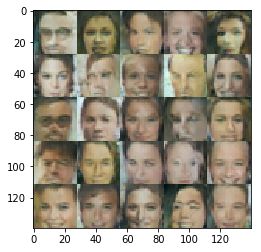

Step 2655... Epoch 1/1... Batch 2654/3165... D Loss: 0.7908... G Loss: 1.1655
Step 2670... Epoch 1/1... Batch 2669/3165... D Loss: 0.8284... G Loss: 1.2128
Step 2685... Epoch 1/1... Batch 2684/3165... D Loss: 0.9216... G Loss: 0.7853
Step 2700... Epoch 1/1... Batch 2699/3165... D Loss: 1.0012... G Loss: 1.0577
Step 2715... Epoch 1/1... Batch 2714/3165... D Loss: 1.0000... G Loss: 0.6768
Step 2730... Epoch 1/1... Batch 2729/3165... D Loss: 0.8756... G Loss: 0.7420
Step 2745... Epoch 1/1... Batch 2744/3165... D Loss: 1.3417... G Loss: 0.4687
Step 2760... Epoch 1/1... Batch 2759/3165... D Loss: 0.6573... G Loss: 1.2763
Step 2775... Epoch 1/1... Batch 2774/3165... D Loss: 0.7943... G Loss: 0.9941
Step 2790... Epoch 1/1... Batch 2789/3165... D Loss: 0.7184... G Loss: 1.0219
Step 2805... Epoch 1/1... Batch 2804/3165... D Loss: 0.8146... G Loss: 1.2756


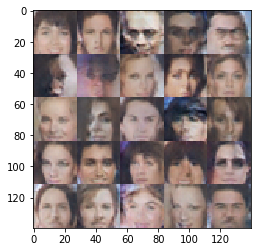

Step 2820... Epoch 1/1... Batch 2819/3165... D Loss: 1.0782... G Loss: 0.7185
Step 2835... Epoch 1/1... Batch 2834/3165... D Loss: 1.1510... G Loss: 0.5710
Step 2850... Epoch 1/1... Batch 2849/3165... D Loss: 0.8015... G Loss: 1.0755
Step 2865... Epoch 1/1... Batch 2864/3165... D Loss: 0.9079... G Loss: 1.1695
Step 2880... Epoch 1/1... Batch 2879/3165... D Loss: 1.0198... G Loss: 0.8122
Step 2895... Epoch 1/1... Batch 2894/3165... D Loss: 1.1974... G Loss: 0.5543
Step 2910... Epoch 1/1... Batch 2909/3165... D Loss: 0.8799... G Loss: 1.6957
Step 2925... Epoch 1/1... Batch 2924/3165... D Loss: 1.1208... G Loss: 0.5498
Step 2940... Epoch 1/1... Batch 2939/3165... D Loss: 0.6574... G Loss: 1.1950
Step 2955... Epoch 1/1... Batch 2954/3165... D Loss: 0.6902... G Loss: 1.0289


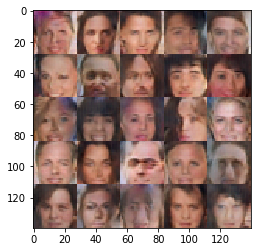

Step 2970... Epoch 1/1... Batch 2969/3165... D Loss: 0.7640... G Loss: 1.0842
Step 2985... Epoch 1/1... Batch 2984/3165... D Loss: 0.8954... G Loss: 0.9597
Step 3000... Epoch 1/1... Batch 2999/3165... D Loss: 0.8097... G Loss: 1.5073
Step 3015... Epoch 1/1... Batch 3014/3165... D Loss: 1.4333... G Loss: 0.3653
Step 3030... Epoch 1/1... Batch 3029/3165... D Loss: 0.7991... G Loss: 1.1731
Step 3045... Epoch 1/1... Batch 3044/3165... D Loss: 0.8907... G Loss: 0.9106
Step 3060... Epoch 1/1... Batch 3059/3165... D Loss: 0.9912... G Loss: 0.6563
Step 3075... Epoch 1/1... Batch 3074/3165... D Loss: 1.1531... G Loss: 0.5135
Step 3090... Epoch 1/1... Batch 3089/3165... D Loss: 1.1681... G Loss: 0.5578
Step 3105... Epoch 1/1... Batch 3104/3165... D Loss: 0.7881... G Loss: 1.1051
Step 3120... Epoch 1/1... Batch 3119/3165... D Loss: 0.4776... G Loss: 1.6641


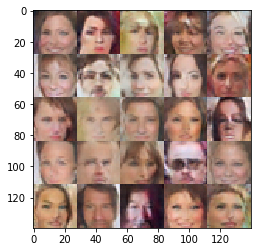

Step 3135... Epoch 1/1... Batch 3134/3165... D Loss: 0.8057... G Loss: 1.9170
Step 3150... Epoch 1/1... Batch 3149/3165... D Loss: 1.0099... G Loss: 0.7548
Step 3165... Epoch 1/1... Batch 3164/3165... D Loss: 2.4499... G Loss: 3.3681


In [14]:
batch_size = 64
z_dim = 200
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

files = glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))
celeba_dataset = helper.Dataset('celeba', files)
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode, len(files))

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.